In [5]:
##Zadanie 4 Laboratorium 2
##Implementacja obliczania wartości własnych macierzy Hessenberga

##Input:
#H - Górna macierz Hessenberga (tablica NumPy 2D)
#tol - tolerancja zbieżności (liczba zmiennoprzecinkowa)
#max_iter - maksymalna liczba iteracji (liczba całkowita)
##Output
#eigenvalues - wartości własne macierzy (tablica NumPy 1D)

import numpy as np

def eigenvalues(H, tol, max_iter):
    n = H.shape[0]
    H_k = H.copy()

    for _ in range(max_iter):
        Q, R = np.linalg.qr(H_k)
        H_k = R @ Q

        off_diagonal_norm = np.linalg.norm(np.tril(H_k, -1))
        if off_diagonal_norm < tol:
            break

    return np.diag(H_k)

H = np.array([[1, 2, -1],
              [1, 4, 5],
              [1, 4, 1]])

eigenvalues_result = eigenvalues(H, 1e-10, 1000)
print(f"Wartości własne: {eigenvalues_result}")


Wartości własne: [ 7.46410468 -2.00025454  0.53614986]



Macierz 5x5
Znaleziona wartość własna: -0.7752525984902818

Macierz 10x10
Znaleziona wartość własna: -0.9138520308573934

Macierz 15x15
Znaleziona wartość własna: -0.7812686337264448

Macierz 20x20
Znaleziona wartość własna: -0.6819797906280552


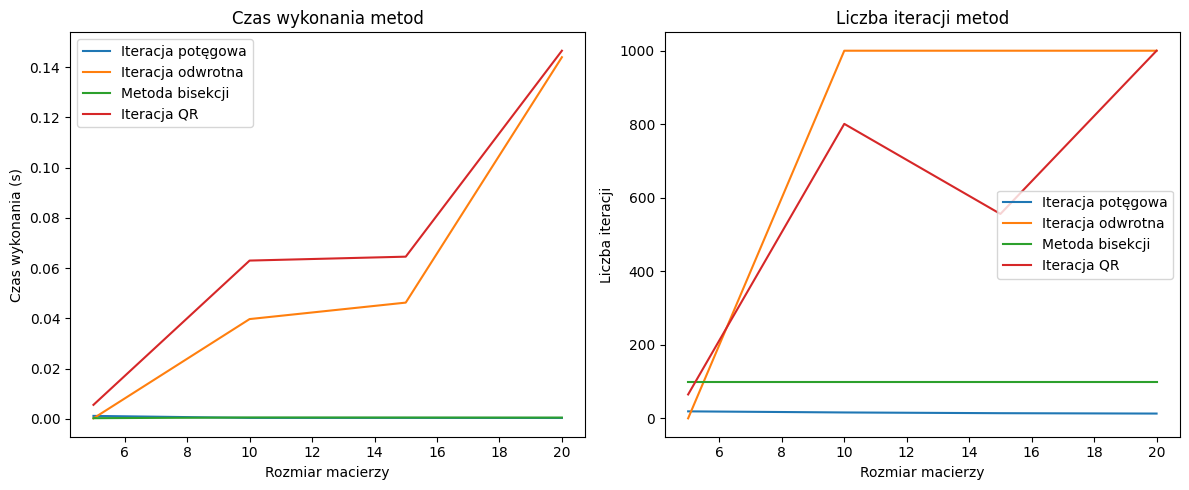

In [20]:
##Zadanie 5 Laboratorium 2
##Porównanie metod obliczania wartości własnych
##Input:
#Losowo generowane macierze
##Output:
#Porównanie wskaźników zbieżności i dokładność każdej metody (wypisy, wykresy, itp.)

##Metody wybrane dla porównania:
#1. Iteracja potęgowa
#2. Iteracja odwrotna
#3. Metoda bisekcji (dla macierzy diagonalizowalnych)
#4. Iteracja QR (dla macierzy Heissenberga)

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import hessenberg

#Metoda iteracji potęgowej
def iteracja_potegowa(A, tol=1e-10, max_iter=1000):
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)

    for i in range(max_iter):
        v_new = A @ v
        v_new /= np.linalg.norm(v_new)
        if np.linalg.norm(v_new - v) < tol:
            break
        v = v_new

    eigenvalue = (v.T @ A @ v) / (v.T @ v)
    return eigenvalue, i + 1

#Metoda iteracji odwrotnej
def iteracja_odwrotna(A, mu, tol=1e-10, max_iter=1000):
    n = A.shape[0]
    v = np.random.rand(n)
    v /= np.linalg.norm(v)

    for i in range(max_iter):
        try:
            v_new = np.linalg.solve(A - mu * np.eye(n), v)
        except np.linalg.LinAlgError:
            return None, i
        v_new /= np.linalg.norm(v_new)
        if np.linalg.norm(v_new - v) < tol:
            break
        v = v_new

    eigenvalue = (v.T @ A @ v) / (v.T @ v)
    return eigenvalue, i + 1

#Metoda iteracji QR
def iteracja_qr(H, tol=1e-10, max_iter=1000):
    H_k = H.copy()
    for i in range(max_iter):
        Q, R = np.linalg.qr(H_k)
        H_k = R @ Q

        if np.linalg.norm(np.tril(H_k, -1)) < tol:
            break

    return np.diag(H_k), i + 1

#Metoda bisekcji dla macierzy diagonalizowalnych
def compute_omega(lambda_val, delta, gamma_squared):
    n = len(delta)
    omega = [0] * (n + 1)
    omega[0] = 1
    omega[1] = delta[0] - lambda_val

    for i in range(2, n + 1):
        omega[i] = (delta[i-1] - lambda_val) * omega[i-1] - gamma_squared[i-2] * omega[i-2]

    return omega

def count_sign_changes(sequence):
    count = 0
    for i in range(1, len(sequence)):
        if sequence[i-1] * sequence[i] < 0:
            count += 1
    return count

def metoda_bisekcji(delta, gamma_squared, a, b, tol=1e-6, max_iter=100):
    for _ in range(max_iter):
        mid = (a + b) / 2
        omega = compute_omega(mid, delta, gamma_squared)
        W_lambda = omega[-1]

        if abs(W_lambda) < tol:
            return mid

        sign_changes = count_sign_changes(omega)

        if sign_changes > 0:
            b = mid
        else:
            a = mid

    return (a + b) / 2

#Główny kod porównujący metody
np.random.seed(42)
sizes = [5, 10, 15, 20]
methods = ["Iteracja potęgowa", "Iteracja odwrotna", "Metoda bisekcji", "Iteracja QR"]
times = {method: [] for method in methods}
iterations = {method: [] for method in methods}

for size in sizes:
    print(f"\nMacierz {size}x{size}")

    #Losowa macierz symetryczna
    A = np.random.rand(size, size)
    A = (A + A.T) / 2  # Upewniamy się, że macierz jest symetryczna

    #Macierz Hessenberga
    H = hessenberg(A)

    #Metoda potęgowa
    start = time.time()
    eig_power, iters_power = iteracja_potegowa(A)
    times["Iteracja potęgowa"].append(time.time() - start)
    iterations["Iteracja potęgowa"].append(iters_power)

    #Iteracja odwrotna
    mu = np.median(np.linalg.eigvals(A))
    start = time.time()
    eig_inv, iters_inv = iteracja_odwrotna(A, mu)
    times["Iteracja odwrotna"].append(time.time() - start)
    iterations["Iteracja odwrotna"].append(iters_inv)

    #Metoda bisekcji
    start = time.time()
    delta = np.diag(A)
    gamma_squared = [A[i, i+1]**2 for i in range(size-1)]

    #Przedział początkowy
    a = min(delta) - 1
    b = max(delta) + 1

    #Znajdowanie wartości własnej
    eigenvalue = metoda_bisekcji(delta, gamma_squared, a, b)
    print("Znaleziona wartość własna:", eigenvalue)
    times["Metoda bisekcji"].append(time.time() - start)
    iterations["Metoda bisekcji"].append(100)

    #Iteracja QR
    start = time.time()
    eig_qr, iters_qr = iteracja_qr(H)
    times["Iteracja QR"].append(time.time() - start)
    iterations["Iteracja QR"].append(iters_qr)

#Wyniki - wykresy
plt.figure(figsize=(12, 5))

#Wykres czasu wykonania
plt.subplot(1, 2, 1)
for method in methods:
    plt.plot(sizes, times[method], label=method)
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas wykonania (s)")
plt.title("Czas wykonania metod")
plt.legend()

#Wykres iteracji
plt.subplot(1, 2, 2)
for method in methods:
    plt.plot(sizes, iterations[method], label=method)
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Liczba iteracji")
plt.title("Liczba iteracji metod")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
##Zadanie 1 Laboratorium 3
##Implementacja metody QR do obliczania wartości własnych macierzy trójdiagonalnej symetrycznej

##Input:
#diag: elementy diagonalne macierzy trójprzekątnej (tablica NumPy 1D)
#off_diag: elementy poza diagonalą macierzy trójprzekątnej (tablica NumPy 1D)
#tol: tolerancja zbieżności (liczba zmiennoprzecinkowa)
#max_iter: maksymalna liczba iteracji (liczba całkowita)

##Output:
#eigenvalues: Wartości własne macierzy (tablica NumPy 1D)

import numpy as np

def eigenvalues_qr_tridiagonal(diag, off_diag, tol=1e-10, max_iter=1000):
  n = len(diag)

  A = np.diag(diag) + np.diag(off_diag, k = 1) + np.diag(off_diag, k = -1)

  for _ in range(max_iter):
    Q, R = np.linalg.qr(A)
    A = R @ Q
    if np.linalg.norm(np.tril(A, -1), ord='fro') < tol:
      break

  return np.diag(A)

diag = np.array([4, 5, 6, 7])
off_diag = np.array([1, 1, 1])
eigenvalues = eigenvalues_qr_tridiagonal(diag, off_diag)
print("Wartości własne:", eigenvalues)

Wartości własne: [7.74528124 6.17728292 4.82271708 3.25471876]


In [19]:
##Zadanie 2 Laboratorium 3
##Implementacja metody QR do obliczania wartości własnych macierzy Hessenberga w przeciwnym kierunku

##Input:
#H: dolna macierz Hessenberga (tablica NumPy 2D)
#tol: tolerancja zbieżności (liczba zmiennoprzecinkowa)
#max_iter: maksymalna liczba iteracji (liczba całkowita)

##Output
#eigenvalues: wartości własne macierzy (tablica NumPy 1D)

import numpy as np

def eigenvalues_qr_hessenberg_reverse(H, tol=1e-10, max_iter=6000):
    H_k = H.copy()

    for iteration in range(max_iter):
        Q, R = np.linalg.qr(H_k)

        H_k = R @ Q

        off_diagonal_norm = np.linalg.norm(np.triu(H_k, 1), ord='fro')

        if off_diagonal_norm < tol:
            print(f'Zbieżność osiągnięta po {iteration + 1} iteracjach.')
            break

    return np.diag(H_k)

H = np.array([
    [19, 0, 0],
    [7, 20, 0],
    [4, 8, 3]
])

eigenvalues = eigenvalues_qr_hessenberg_reverse(H)
print("Wartości własne:", eigenvalues)

Wartości własne: [20. 19.  3.]
